# Creating Useful Features for Deep Learning
Once we have interpolated and  data we can now predict the internal fields with deep learning, however to increase the performance of our model it is better to use some derived inputs as our fatures.In this notebook we will be creating some useful features for our learning model.

In [1]:
import pathlib as pt
import numpy as np
import pyvista as pv
import pymethods as pma
import pymethods.pyplot as plt
# make the plots interactive
# %matplotlib widget
# change the following to your directory of vtk files. The data has already been 
# processed using the programs in the scripts folder
# unwrapped now all we need to do is add the features to each case
VTK_folder = pt.Path(f"I:\VTK")
# we will only process the first dataset
case_folder = VTK_folder/"00000"

Let us load and visualize the structured mesh with pyvista

In [2]:
data_file = np.load(case_folder/"structured_interpolated_data.npz") 
data_keys = list(data_file.keys())
print(data_keys)

['points', 'U', 'p']


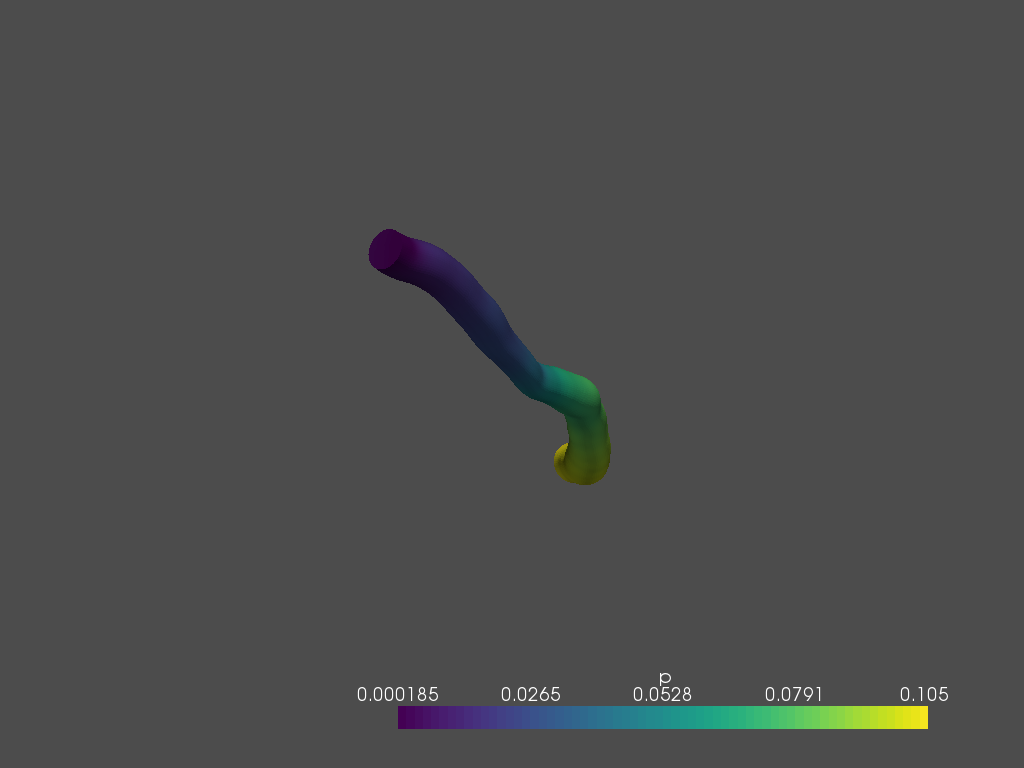

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [3]:
mesh = pv.StructuredGrid(*data_file["points"])
# when setting the data to a structured grid we need to reshape the data using Fortran ordering
mesh.point_arrays["p"] = data_file["p"].reshape(-1, order="F")
mesh.plot()

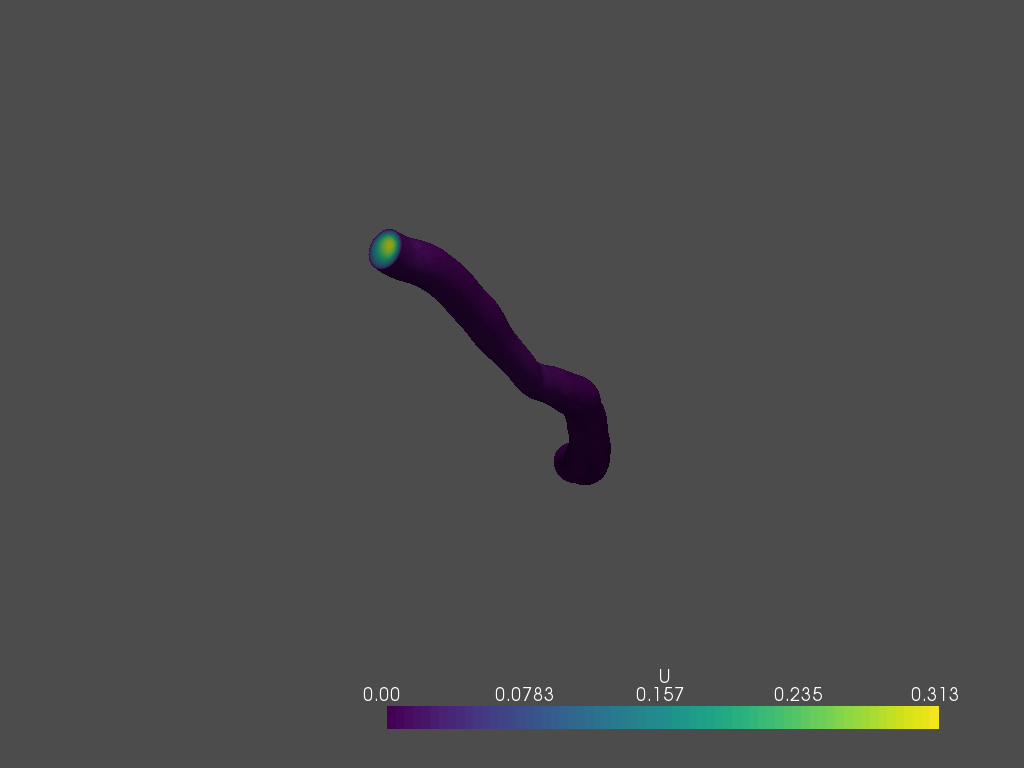

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [4]:
mesh = pv.StructuredGrid(*data_file["points"])
mesh.point_arrays["U"] = data_file["U"].reshape(3, -1, order="F").T
mesh.plot()

We would also just like to view the cross sections so let us generate a helper function to plot the cross sections for us,

In [5]:
def plot_cross_sections(point_data, field, indices="all", ax=None):
    field_stats = pma.math.summary_statistics.SummaryStatistics(field.flatten())
    if ax is None:
        f, ax = plt.figure_3d()
    if indices == "all":
        indices = np.arange(point_data.shape(-1))
    for i in indices:
        cross_section_field = field[:, :, i].reshape(-1)
        flat_points = point_data[:,:,:,i].reshape(3, -1)
        ax.scatter(
            *flat_points,
            c=cross_section_field,
            vmin=field_stats.mu_m_2sigma,
            vmax=field_stats.mu_p_2sigma,
            cmap="jet"
        )

In [7]:
spacing = 50
points = data_file["points"]

fig = plt.figure(figsize=plt.figaspect(0.175))
axes = [fig.add_subplot(1,4,i, projection="3d") for i in range(1,5)]

plot_cross_sections(points, data_file["p"].squeeze(), indices=np.arange(0, 384, spacing), ax=axes[0])
axes[0].set_title("Pressure")

titles =["U_x", "U_y", "U_z"]

for i in range(1, 4):
    plot_cross_sections(points, data_file["U"][i-1].squeeze(), indices=np.arange(0, 384, spacing), ax=axes[i])
    axes[i].set_title(titles[i-1])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The features which we will generate are the curvature along the streamwise direction, the area and the distance along each parametric direction for each point along the mesh. This is to ensure that the input to the deep learning model are normalized and don't vary significantly depending on the location and size of the input artery.

In [8]:
# let us now calculculate the curvatures along the streamwise direction of the artery
c, nu, nv, nw = points.shape
spatial_curvature = np.zeros_like(data_file["p"])
for i in range(nu):
    for j in range(nv):
        curve                         = pma.arrays.Curve(points[:, i, j, :])
        curvature                     = curve.curvature()
        spatial_curvature[:, i, j, :] = curvature

In [9]:
f = plt.figure()
ax = plt.axes(projection="3d")
plot_cross_sections(points, spatial_curvature.squeeze(), indices=np.arange(0, 384, 50), ax=ax)
ax.set_title("Steamwise Curvature")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# calculating the area along each cross section
area = np.zeros_like(data_file["p"])
for i in range(nw):
    frame = points[:, :, :, i]
    contour = np.concatenate(
        [
            frame[:,:,0].reshape(3,-1),
            frame[:,-1,:].reshape(3,-1),
            np.flipud(frame[:,:,-1].reshape(3,-1).T).T,
            np.flipud(frame[:,0,:].reshape(3,-1).T).T,
        ], axis=-1
    )
    contour = pma.arrays.Contour(contour)
    area[:,:,:,i] = contour.area


In [13]:
f = plt.figure()
ax = plt.axes(projection="3d")
plot_cross_sections(points, area.squeeze(), indices=np.arange(0, 384, 50), ax=ax)
ax.set_title("Steamwise Curvature")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
# now calculate the delta between points
delleft       = np.linalg.norm(
                    points[:, :, 1:, :] - points[:, :, :-1, :], axis=0)
delup         = np.linalg.norm(
                    points[:, 1:, :, :] - points[:, :-1, :, :], axis=0)
deldownstream = np.linalg.norm(
                    points[:, :, :, 1:] - points[:, :, :, :-1], axis=0)

_,h,w,d = points.shape

deltas = np.zeros((3, nu, nv, nw))
deltas[0, :, :-1, :] = delleft
deltas[1, :-1, :, :] = delup
deltas[2, :, :, :-1] = deldownstream

In [21]:
spacing = 50
points = data_file["points"]

fig = plt.figure(figsize=plt.figaspect(0.175))
axes = [fig.add_subplot(1,4,i, projection="3d") for i in range(1,4)]

titles =["del left", "del up", "del stream"]

for i in range(1, 4):
    plot_cross_sections(points, deltas[i-1].squeeze(), indices=np.arange(0, 384, spacing), ax=axes[i-1])
    axes[i-1].set_title(titles[i-1])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …